# Pseudo batch transformation


This notebook produces the plots for the for the article and supplemental materials, furthermore contains some experimental plots.

TODO:
- [ ] Do all pseudo batch transformations at the same time using _pandas version
- [ ] Use the fit_ols_model function 

## loading fedbatch data

In [1]:
import sys
import os
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from patsy import dmatrices
import statsmodels.api as sm

from pseudobatch import pseudobatch_transform, pseudobatch_transform_pandas
from pseudobatch.datasets import _p

/Users/s143838/.virtualenvs/pseudobatch-dev/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'stan_version_major': '2', 'stan_version_minor': '29', 'stan_version_patch': '2', 'STAN_THREADS': 'false', 'STAN_MPI': 'false', 'STAN_OPENCL': 'false', 'STAN_NO_RANGE_CHECKS': 'false', 'STAN_CPP_OPTIMS': 'false'}


In [2]:
FIGURES_DIR = pathlib.Path('../figures')

In [3]:
fedbatch_df = load_standard_fedbatch()

To calculate the consumed glucose we require a measurement of the glucose concentration when the feeding is initiated (time 0). Here we assume that we have a measurement at time 0, but if a measurement is not available therefore several options:
1. Assume that initial glucose is 0. If the fed-batch is properly setup, the glucose concentration should be small at time 0. Thus, this assumption should not bias the results significantly. 
2. Estimate the concentration based on experience from similar batch cultures

As stated earlier fed-batch fermentations typically has a low substrate concentration when the feeding is initiated. 

The the initial glucose concentration typically constitute a small fraction of the substrate add over the hole course of the fed-batch process. Thus in most cases it is not crucial to have a very accurate estimate of the initial substrate concentration. One should be cautious if the feeding phase the short, or if the initial substrate concentration is significant compared to the substrate added through feeding.

In [4]:
# calculate consumed glucose
initial_m_glucose = fedbatch_df['m_Glucose'].iloc[0]
glucose_conc_in_feed = fedbatch_df.s_f.iloc[0] 
fedbatch_df['m_consumed_Glucose'] = initial_m_glucose + fedbatch_df['v_Feed_accum'] * glucose_conc_in_feed - fedbatch_df['m_Glucose']  

In [5]:
fedbatch_df_measurements_only = (fedbatch_df
    .query('sample_volume > 0')
    .copy()
)

### Overview of the simulation
First, I will visualize the fedbatch measurements data.

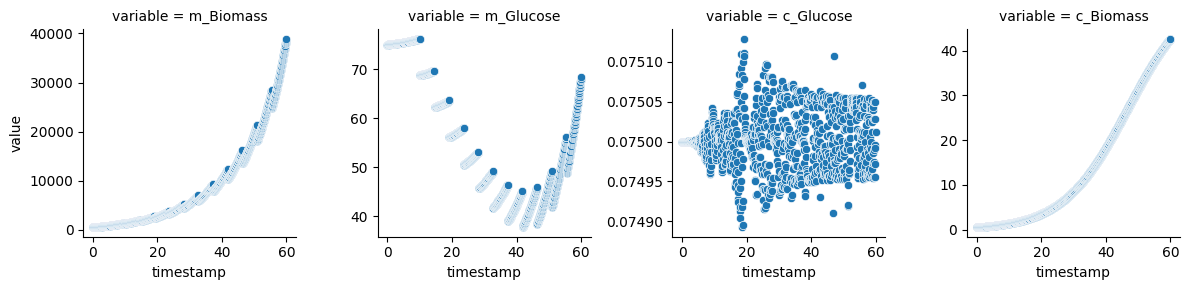

In [6]:
plot_dat = (fedbatch_df
    .filter(items=["timestamp", "m_Biomass", "m_Glucose", "v_volume",   "v_feed_accum", 'c_Glucose', 'c_Biomass'])
    .melt(id_vars="timestamp")
)
g = sns.FacetGrid(data=plot_dat, col='variable', col_wrap=4, sharey=False, sharex=False)
g.map_dataframe(sns.scatterplot, x='timestamp', y='value')


.....

## Only biomass

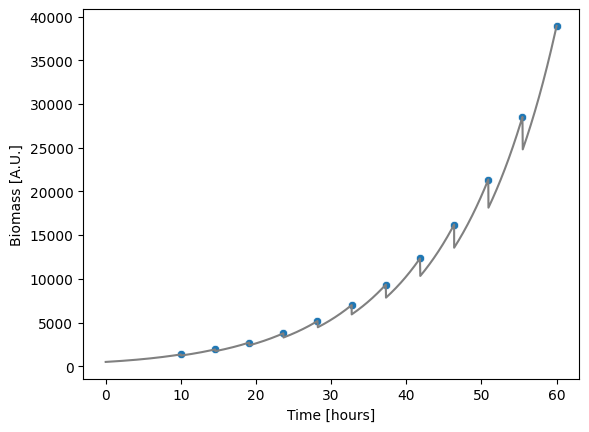

In [12]:
sns.lineplot(data = fedbatch_df, x = 'timestamp', y = 'm_Biomass', color = 'grey')
sns.scatterplot(data = fedbatch_df_measurements_only, x = 'timestamp', y = 'm_Biomass', color = 'C00')
plt.ylabel("Biomass [A.U.]")
plt.xlabel("Time [hours]")
plt.savefig(FIGURES_DIR / 'fedbatch_raw_biomass.png', dpi=300, bbox_inches='tight')

Text(0.5, 0, 'Time [hours]')

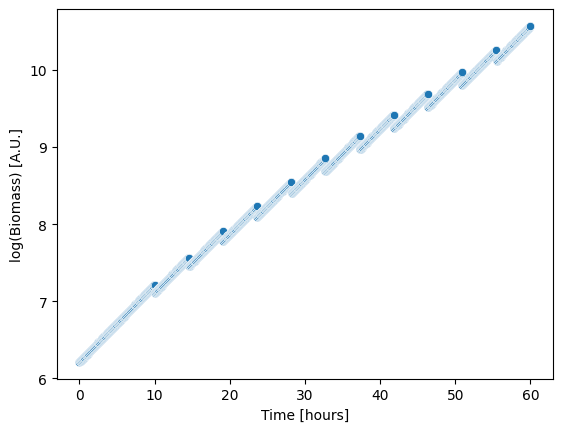

In [8]:
sns.scatterplot(x = fedbatch_df['timestamp'], y = fedbatch_df['m_Biomass'].transform(np.log))
plt.ylabel("log(Biomass) [A.U.]")
plt.xlabel("Time [hours]")


In [9]:
y, X_noncorrected = dmatrices(formula_like = "np.log(m_Biomass) ~ timestamp", data= fedbatch_df_measurements_only)
model_noncorrected = sm.OLS(endog=y, exog=X_noncorrected)
res_noncorrected = model_noncorrected.fit()
mu_hat_noncorrected = res_noncorrected.params[1]
y_pred_noncorrected = res_noncorrected.predict(X_noncorrected)
print(mu_hat_noncorrected)

0.06597174185227486


Text(0.5, 0, 'Time [hours]')

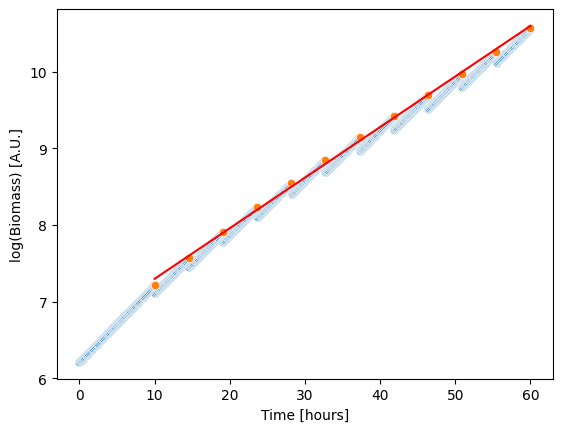

In [10]:
sns.scatterplot(x = fedbatch_df['timestamp'], y = fedbatch_df['m_Biomass'].transform(np.log))
sns.scatterplot(x=fedbatch_df_measurements_only['timestamp'], y = fedbatch_df_measurements_only['m_Biomass'].transform(np.log))
sns.lineplot(x = fedbatch_df_measurements_only.timestamp, y = y_pred_noncorrected, color='red')
plt.ylabel("log(Biomass) [A.U.]")
plt.xlabel("Time [hours]")

Text(0.5, 0, 'Time [hours]')

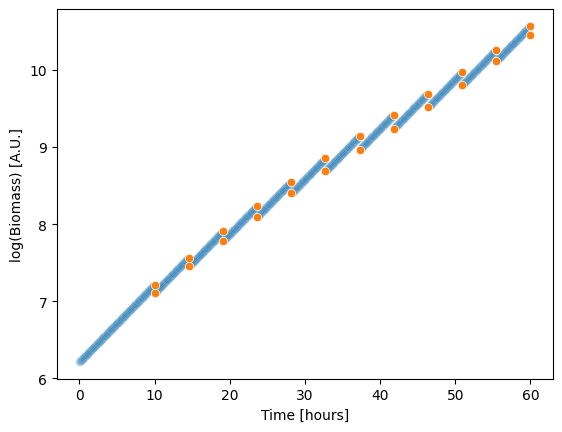

In [11]:
# online measurements
fedbatch_file = os.path.join("..","..", "pseudobatch", "datasets", "data", "standard_fed-batch_process.csv")
fedbatch_df_w_duplicates = pd.read_csv(fedbatch_file, index_col=0)
fedbatch_df_w_duplicates = fedbatch_df_w_duplicates.query("sample_volume > 0")

sns.scatterplot(x = fedbatch_df['timestamp'], y = fedbatch_df['m_Biomass'].transform(np.log), alpha=0.2)
sns.scatterplot(x=fedbatch_df_w_duplicates['timestamp'], y = fedbatch_df_w_duplicates['m_Biomass'].transform(np.log))
plt.ylabel("log(Biomass) [A.U.]")
plt.xlabel("Time [hours]")

## Calculate growth rate using dilution factor correction

Now we can calculate the corrected biomass using the pseudo batch transformation

In [12]:
## Calculates dilution factor and cummulative dilution factor

fedbatch_df["c_Biomass_pseudo"] = pseudobatch_transform(
    measured_concentration=fedbatch_df["c_Biomass"].to_numpy(),
    reactor_volume=fedbatch_df["v_Volume"].to_numpy(),
    accumulated_feed=fedbatch_df["v_Feed_accum"].to_numpy(),
    concentration_in_feed=0,
    sample_volume=fedbatch_df["sample_volume"].fillna(0).to_numpy(),
)
fedbatch_df_measurements_only["c_Biomass_pseudo"] = pseudobatch_transform(
    measured_concentration=fedbatch_df_measurements_only["c_Biomass"].to_numpy(),
    reactor_volume=fedbatch_df_measurements_only["v_Volume"].to_numpy(),
    accumulated_feed=fedbatch_df_measurements_only["v_Feed_accum"].to_numpy(),
    concentration_in_feed=0,
    sample_volume=fedbatch_df_measurements_only["sample_volume"].fillna(0).to_numpy(),
)

Now we use a linear model to fit the growth rate.
$$
log(C_{corrected, \: Biomass}) = a + \mu * t
$$

In [13]:
y, X_corrected = dmatrices(formula_like = "np.log(c_Biomass_pseudo) ~ timestamp", data= fedbatch_df_measurements_only)
model_corrected = sm.OLS(endog=y, exog=X_corrected)
res_corrected = model_corrected.fit()
mu_hat_corrected = res_corrected.params[1]
print("Fitted growth rate from corrected biomass: " + str(res_corrected.params[1]))

Fitted growth rate from corrected biomass: 0.10000016643815146


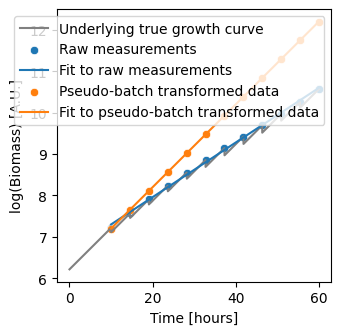

In [14]:
initial_volume = 1000
sns.lineplot(x = fedbatch_df['timestamp'], y = fedbatch_df['m_Biomass'].transform(np.log), label = 'Underlying true growth curve', color='grey')

sns.scatterplot(x=fedbatch_df_measurements_only['timestamp'], y = fedbatch_df_measurements_only['m_Biomass'].transform(np.log), color = 'C0', label = 'Raw measurements')
sns.lineplot(x = fedbatch_df_measurements_only.timestamp, y = y_pred_noncorrected, color='C0', label = 'Fit to raw measurements')

sns.scatterplot(x = fedbatch_df_measurements_only['timestamp'], y = (fedbatch_df_measurements_only['c_Biomass_pseudo'] * initial_volume).transform(np.log), color='C1', label = 'Pseudo-batch transformed data') # the pseudo batch volume in the initial volume (800 uL)
sns.lineplot(x = fedbatch_df_measurements_only.timestamp, y = (res_corrected.predict(X_corrected) + np.log(initial_volume)), color='C1', label = 'Fit to pseudo-batch transformed data') # the predicted values are in log-space there for I add log(800) instead of multiplying


plt.ylabel("log(Biomass) [A.U.]")
plt.xlabel("Time [hours]")
plt.savefig(FIGURES_DIR / "transformed_and_non-transformed_logscale.png", dpi=300)

# resize height and width of figure
fig = plt.gcf()
fig.set_size_inches((3.54, 3.54))
#fig.legend(bbox_to_anchor=(1.2, 0.5), loc='center right', borderaxespad=0.)
fig.savefig(FIGURES_DIR / "transformed_and_non-transformed_logscale_paper.png", dpi=300)

KeyError: 'c_Biomass_pseudo'

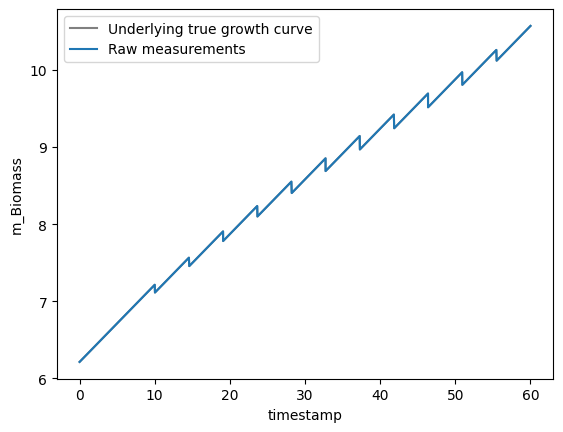

In [14]:
initial_volume = 1000
sns.lineplot(x = fedbatch_df['timestamp'], y = fedbatch_df['m_Biomass'].transform(np.log), label = 'Underlying true growth curve', color='grey')

sns.lineplot(x=fedbatch_df['timestamp'], y = fedbatch_df['m_Biomass'].transform(np.log), color = 'C0', label = 'Raw measurements')

sns.lineplot(x = fedbatch_df['timestamp'], y = (fedbatch_df['c_Biomass_pseudo'] * initial_volume).transform(np.log), color='C1', label = 'Pseudo-batch transformed data') # the pseudo batch volume in the initial volume (800 uL)


## How to calculate yields using the corrected fedbatch data
....

In [15]:
# correct glucose data
fedbatch_df["c_Glucose_pseudo"] = pseudobatch_transform(
        measured_concentration=fedbatch_df['c_Glucose'].to_numpy(),
        reactor_volume=fedbatch_df['v_Volume'].to_numpy(),
        accumulated_feed=fedbatch_df['v_Feed_accum'].to_numpy(),
        concentration_in_feed=fedbatch_df.s_f.iloc[0], # the first value of the feed is the concentration of glucose in the feed
        sample_volume=fedbatch_df['sample_volume'].fillna(0).to_numpy() # the sample volume column contains nan when at times where no sample was taken
    )
fedbatch_df_measurements_only["c_Glucose_pseudo"] = pseudobatch_transform(
    measured_concentration=fedbatch_df_measurements_only["c_Glucose"].to_numpy(),
    reactor_volume=fedbatch_df_measurements_only["v_Volume"].to_numpy(),
    accumulated_feed=fedbatch_df_measurements_only["v_Feed_accum"].to_numpy(),
    concentration_in_feed=fedbatch_df.s_f.iloc[0], # the first value of the feed is the concentration of glucose in the feed
    sample_volume=fedbatch_df_measurements_only["sample_volume"].fillna(0).to_numpy(),
)

In [16]:
# Calculate the consumed pseudo conconcentrations
initial_glucose_pseudo = fedbatch_df["c_Glucose_pseudo"].iloc[0]
fedbatch_df["c_consumed_Glucose_pseudo"] = initial_glucose_pseudo - fedbatch_df["c_Glucose_pseudo"]
fedbatch_df_measurements_only["c_consumed_Glucose_pseudo"] = initial_glucose_pseudo - fedbatch_df_measurements_only["c_Glucose_pseudo"]

We can calculate the consumed pseudo batch glucose simply by taking the absolute value of the pseudo batch concentrations.

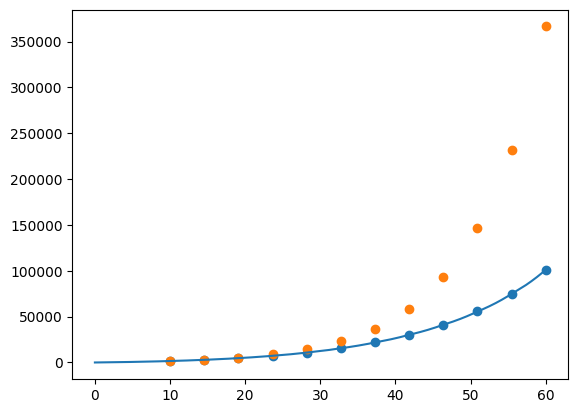

In [17]:
plt.scatter(fedbatch_df_measurements_only['timestamp'], fedbatch_df_measurements_only['m_consumed_Glucose'])
plt.scatter(fedbatch_df_measurements_only['timestamp'], fedbatch_df_measurements_only['c_consumed_Glucose_pseudo'] * initial_volume)
plt.plot(fedbatch_df['timestamp'], fedbatch_df['m_consumed_Glucose'])

In [18]:
y, X_yxs_noncorrected = dmatrices(formula_like = "m_consumed_Glucose ~ m_Biomass", data= fedbatch_df_measurements_only)
model_yxs_noncorrected = sm.OLS(endog=y, exog=X_yxs_noncorrected)
res_yxs_noncorrected = model_yxs_noncorrected.fit()
yxs_hat_yxs_noncorrected = res_yxs_noncorrected.params[1]
y_pred_yxs_noncorrected = res_yxs_noncorrected.predict(X_yxs_noncorrected)
print(yxs_hat_yxs_noncorrected)

2.6884067643415035


In [19]:
y, X_yxs_corrected = dmatrices(formula_like = "c_consumed_Glucose_pseudo ~ c_Biomass_pseudo", data= fedbatch_df_measurements_only)
model_yxs_corrected = sm.OLS(endog=y, exog=X_yxs_corrected)
res_yxs_corrected = model_yxs_corrected.fit()
yxs_hat_yxs_corrected = res_yxs_corrected.params[1]
print(yxs_hat_yxs_corrected)


1.8499999999999996


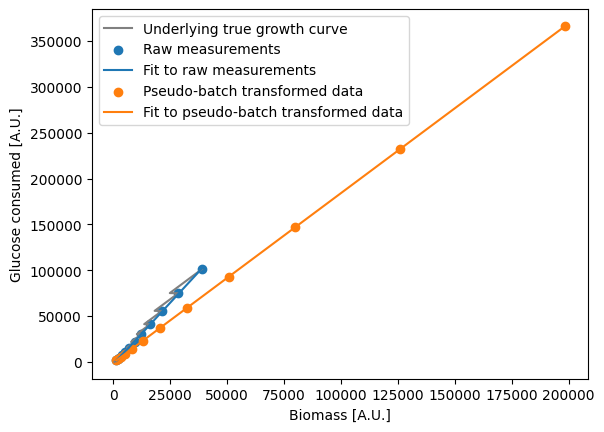

In [20]:
plt.plot(fedbatch_df['m_Biomass'], fedbatch_df['m_consumed_Glucose'], label='Underlying true growth curve', color='grey')
plt.scatter(fedbatch_df_measurements_only['m_Biomass'], fedbatch_df_measurements_only['m_consumed_Glucose'], label='Raw measurements')
plt.plot(fedbatch_df_measurements_only['m_Biomass'], y_pred_yxs_noncorrected, label='Fit to raw measurements')
plt.scatter(fedbatch_df_measurements_only['c_Biomass_pseudo']*initial_volume, fedbatch_df_measurements_only['c_consumed_Glucose_pseudo']*initial_volume, label='Pseudo-batch transformed data')
plt.plot(fedbatch_df_measurements_only['c_Biomass_pseudo']*initial_volume, res_yxs_corrected.predict(X_yxs_corrected)*initial_volume, label='Fit to pseudo-batch transformed data')
plt.ylabel("Glucose consumed [A.U.]")
plt.xlabel("Biomass [A.U.]")
plt.legend()

In [21]:
y, X_rs_corrected = dmatrices(formula_like = "np.log(np.abs(c_Glucose_pseudo)) ~ timestamp", data= fedbatch_df_measurements_only)
model_rs_corrected = sm.OLS(endog=y, exog=X_rs_corrected)
res_rs_corrected = model_rs_corrected.fit()
rs_hat_rs_corrected = res_rs_corrected.params[1]
print(rs_hat_rs_corrected)

0.10765642044932154


Calculating the specific glucose uptake rate using np.gradient() which calculates the finite difference between the points.

In [22]:
rs_hat = np.gradient(fedbatch_df_measurements_only.c_Glucose_pseudo.to_numpy(), fedbatch_df_measurements_only.timestamp) / fedbatch_df_measurements_only.c_Biomass_pseudo.to_numpy()
rs_hat / mu_hat_corrected

array([-2.34212059, -1.91431442, -1.91439554, -1.9143768 , -1.91437364,
       -1.91436873, -1.91436143, -1.91436351, -1.91436396, -1.91436568,
       -1.91436423, -1.48662025])

The method perform reasonably well, but is slightly biased. This is mostly due to the centering of the biomass division. This introduce a bias because the cells grow exponentially and not linearly.

## Calculate product yield

In [23]:
fedbatch_df["c_Product_pseudo"] = pseudobatch_transform(
    measured_concentration=fedbatch_df["c_Product"].to_numpy(),
    reactor_volume=fedbatch_df["v_Volume"].to_numpy(),
    accumulated_feed=fedbatch_df["v_Feed_accum"].to_numpy(),
    concentration_in_feed=0,
    sample_volume=fedbatch_df["sample_volume"].fillna(0).to_numpy(),
)
fedbatch_df_measurements_only["c_Product_pseudo"] = pseudobatch_transform(
    measured_concentration=fedbatch_df_measurements_only["c_Product"].to_numpy(),
    reactor_volume=fedbatch_df_measurements_only["v_Volume"].to_numpy(),
    accumulated_feed=fedbatch_df_measurements_only["v_Feed_accum"].to_numpy(),
    concentration_in_feed=0,
    sample_volume=fedbatch_df_measurements_only["sample_volume"].fillna(0).to_numpy(),
)

In [24]:
def fit_ols_model(formula_like: str, data: pd.DataFrame) -> sm.regression.linear_model.RegressionResultsWrapper:
    y, X = dmatrices(formula_like, data)
    model = sm.OLS(endog=y, exog=X)
    res = model.fit()
    return res

In [25]:
res_yxp_noncorrected = fit_ols_model(formula_like = "m_Product ~ m_Biomass", data= fedbatch_df_measurements_only)
res_yxp_corrected = fit_ols_model(formula_like = "c_Product_pseudo ~ c_Biomass_pseudo", data= fedbatch_df_measurements_only)

print(res_yxp_noncorrected.params[1])
print(res_yxp_corrected.params[1])
print(fedbatch_df.Yxp.iloc[0])

0.8296739566642375
0.8215102466751044
0.8215102466751038


## Calculate CO2 yield

In [26]:
fedbatch_df.columns

Index(['Kc_s', 'mu_max', 'Yxs', 'Yxp', 'Yxco2', 'F0', 'mu0', 's_f',
       'sample_volume', 'timestamp', 'm_Glucose', 'm_Biomass', 'm_Product',
       'm_CO2', 'v_Volume', 'v_Feed_accum', 'c_Glucose', 'c_Biomass',
       'c_Product', 'c_CO2', 'mu_true', 'm_consumed_Glucose',
       'c_Biomass_pseudo', 'c_Glucose_pseudo', 'c_consumed_Glucose_pseudo',
       'c_Product_pseudo'],
      dtype='object')

In [27]:
fedbatch_df["c_CO2_pseudo"] = pseudobatch_transform(
    measured_concentration=fedbatch_df["c_CO2"].to_numpy(),
    reactor_volume=fedbatch_df["v_Volume"].to_numpy(),
    accumulated_feed=fedbatch_df["v_Feed_accum"].to_numpy(),
    concentration_in_feed=0,
    sample_volume=fedbatch_df["sample_volume"].fillna(0).to_numpy(),
)
fedbatch_df_measurements_only["c_CO2_pseudo"] = pseudobatch_transform(
    measured_concentration=fedbatch_df_measurements_only["c_CO2"].to_numpy(),
    reactor_volume=fedbatch_df_measurements_only["v_Volume"].to_numpy(),
    accumulated_feed=fedbatch_df_measurements_only["v_Feed_accum"].to_numpy(),
    concentration_in_feed=0,
    sample_volume=fedbatch_df_measurements_only["sample_volume"].fillna(0).to_numpy(),
)

In [28]:
def fit_ols_model(formula_like: str, data: pd.DataFrame) -> sm.regression.linear_model.RegressionResultsWrapper:
    y, X = dmatrices(formula_like, data)
    model = sm.OLS(endog=y, exog=X)
    res = model.fit()
    return res

In [29]:
res_yxco2_noncorrected = fit_ols_model(formula_like = "m_CO2 ~ m_Biomass", data= fedbatch_df_measurements_only)
res_yxco2_corrected = fit_ols_model(formula_like = "c_CO2_pseudo ~ c_Biomass_pseudo", data= fedbatch_df_measurements_only)

print(res_yxco2_noncorrected.params[1])
print(res_yxco2_corrected.params[1])
print(fedbatch_df.Yxco2.iloc[0])

0.04564243854099134
0.045193332445214146
0.0451933324452141


In [30]:
overview_table_raw = pd.DataFrame.from_dict({
        "Yxs": [res_yxs_noncorrected.params[1], res_yxs_corrected.params[1], fedbatch_df.Yxs.iloc[0]],
        "Yxp": [res_yxp_noncorrected.params[1], res_yxp_corrected.params[1], fedbatch_df.Yxp.iloc[0]],
        "Yxco2": [res_yxco2_noncorrected.params[1], res_yxco2_corrected.params[1], fedbatch_df.Yxco2.iloc[0]],
        "mu": [mu_hat_noncorrected, mu_hat_corrected, fedbatch_df.mu_true.iloc[0]],
    }, 
    columns=[
        "Non-corrected", "Corrected", "True"
    ],
    orient="index",
)

In [31]:
def relative_error(true_value, predicted_value):
    return (true_value - predicted_value) / true_value

def combine_value_and_error(value: float, error: float)-> str:
    return f"{value:.2f} ({error:.2f})"

def prepare_output_strings(true_value: float, predicted_value: float)-> str:
    error = relative_error(true_value, predicted_value)
    error_in_percent = error * 100
    return [combine_value_and_error(value=v, error=e) for v, e in zip(predicted_value, error)]


In [32]:
overview_table_clean = (
    overview_table_raw
    .assign(rel_error_noncorrected=prepare_output_strings(overview_table_raw["True"], overview_table_raw["Non-corrected"]))
    .assign(rel_error_corrected=prepare_output_strings(overview_table_raw["True"], overview_table_raw["Corrected"]))
    .round(2)
    .rename(columns={
        "rel_error_noncorrected": "Non-corrected (rel. error \%)",
        "rel_error_corrected": "Corrected (rel. error \%)"
    })
    .drop(columns=["Non-corrected", "Corrected"])
)
overview_table_clean

,True,Non-corrected (rel. error \%),Corrected (rel. error \%)
Yxs,1.85,2.69 (-0.45),1.85 (0.00)
Yxp,0.82,0.83 (-0.01),0.82 (-0.00)
Yxco2,0.05,0.05 (-0.01),0.05 (-0.00)
mu,0.10,0.07 (0.34),0.10 (-0.00)


In [33]:

# print(
#     overview_table_clean
#     .style # produces a pandas Styler object
#     .format(precision=2) # sets the precision of the displayed values
#     .to_latex()
# )

# Product inhibited growth

In [34]:
dat = (pd.read_csv(os.path.join("~/projects/fermentation_simulator/simulated_data", "product_inhibition.csv"))
    .drop_duplicates('timestamp', keep='first')
    .fillna({'sample_volume':0})
    .reset_index(drop=True)
)
print(dat.columns)
print(dat.shape)

Index(['Kc_s', 'mu_max', 'Yxs', 'Yxp', 'Yxco2', 'F0', 'mu0', 's_f', 'Ki_p',
       'sample_volume', 'p', 'timestamp', 'm_Glucose', 'm_Biomass',
       'm_Product', 'm_CO2', 'v_Volume', 'v_Feed_accum', 'c_Glucose',
       'c_Biomass', 'c_Product', 'c_CO2', 'c_Volume', 'c_Feed', 'mu_true'],
      dtype='object')
(1011, 25)


In [35]:
# calculate consumed glucose
initial_m_glucose = dat['m_Glucose'].iloc[0]
glucose_conc_in_feed = eval(dat.p[0])[7]
dat['m_consumed_Glucose'] = initial_m_glucose + dat['v_Feed_accum'] * glucose_conc_in_feed - dat['m_Glucose']  

In [36]:
from pseudobatch import pseudobatch_transform_pandas
concentration_in_feed = [0, glucose_conc_in_feed, 0]

species_to_correct = ["c_Biomass", "c_Glucose", "c_Product"]

dat[['c_Biomass_pseudo', 'c_Glucose_pseudo', 'c_Product_pseudo']]= pseudobatch_transform_pandas(
    dat,
    ['c_Biomass', 'c_Glucose', 'c_Product'],
    'v_Volume',
    'v_Feed_accum',
    concentration_in_feed,
    'sample_volume'
)

In [37]:
dat_samples = dat.query("sample_volume > 0")


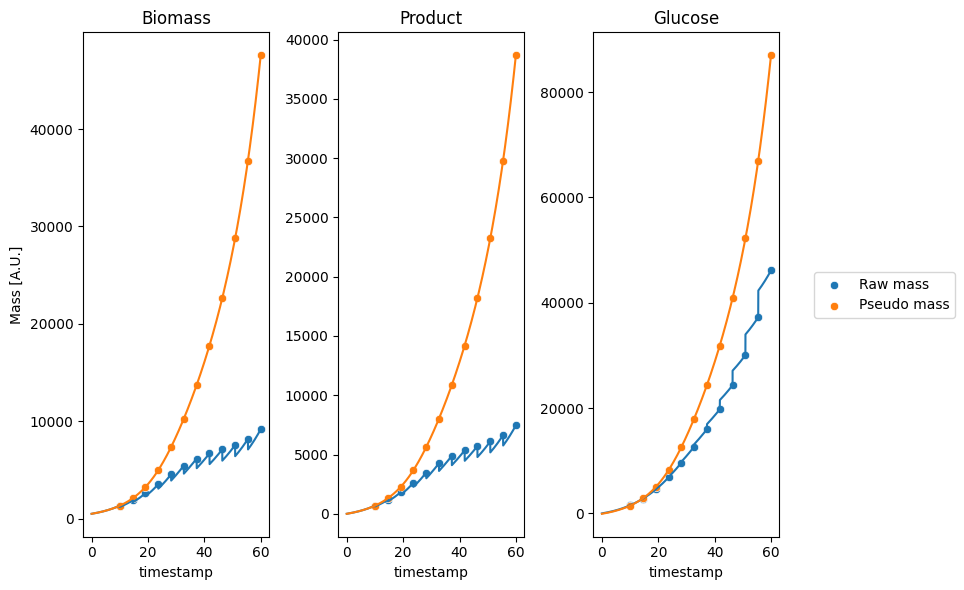

In [38]:
initial_volume = dat['v_Volume'].iloc[0]
fig, axes = plt.subplots(1,3)

sns.lineplot(x=dat['timestamp'], y = dat['m_Product'], ax=axes[1], label = 'Raw mass')
sns.lineplot(x=dat['timestamp'], y = dat['m_Biomass'], ax=axes[0], label = 'Raw mass')
sns.lineplot(x=dat['timestamp'], y = dat['m_consumed_Glucose'], ax=axes[2], label = 'Raw mass')
sns.lineplot(x=dat['timestamp'], y = dat['c_Product_pseudo'] * initial_volume, ax=axes[1], label = 'Pseudo mass')
sns.lineplot(x=dat['timestamp'], y = dat['c_Biomass_pseudo'] * initial_volume, ax=axes[0], label = 'Pseudo mass')
sns.lineplot(x=dat['timestamp'], y = -1 * dat['c_Glucose_pseudo'] * initial_volume, ax=axes[2], label = 'Pseudo mass')

sns.scatterplot(x=dat_samples['timestamp'], y = dat_samples['m_Product'], ax=axes[1], label = 'Raw mass')
sns.scatterplot(x=dat_samples['timestamp'], y = dat_samples['m_Biomass'], ax=axes[0], label = 'Raw mass')
sns.scatterplot(x=dat_samples['timestamp'], y = dat_samples['m_consumed_Glucose'], ax=axes[2], label = 'Raw mass')
sns.scatterplot(x=dat_samples['timestamp'], y = dat_samples['c_Product_pseudo'] * initial_volume, ax=axes[1], label = 'Pseudo mass')
sns.scatterplot(x=dat_samples['timestamp'], y = dat_samples['c_Biomass_pseudo'] * initial_volume, ax=axes[0], label = 'Pseudo mass')
sns.scatterplot(x=dat_samples['timestamp'], y = -1 * dat_samples['c_Glucose_pseudo'] * initial_volume, ax=axes[2], label = 'Pseudo mass')

axes[1].set_title("Product")
axes[0].set_title("Biomass")
axes[2].set_title("Glucose")

for ax in axes:
    ax.get_legend().remove()
    ax.set_ylabel('')
axes[0].set_ylabel('Mass [A.U.]')

# drop duplicated labels
handles, labels = fig.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.set_size_inches((8,6))
fig.tight_layout()
fig.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.2, 0.5),
                         loc='center right', borderaxespad=0.)

fig.savefig(FIGURES_DIR / "mass_time_course_product_inhibit.png", dpi = 300, bbox_inches='tight')

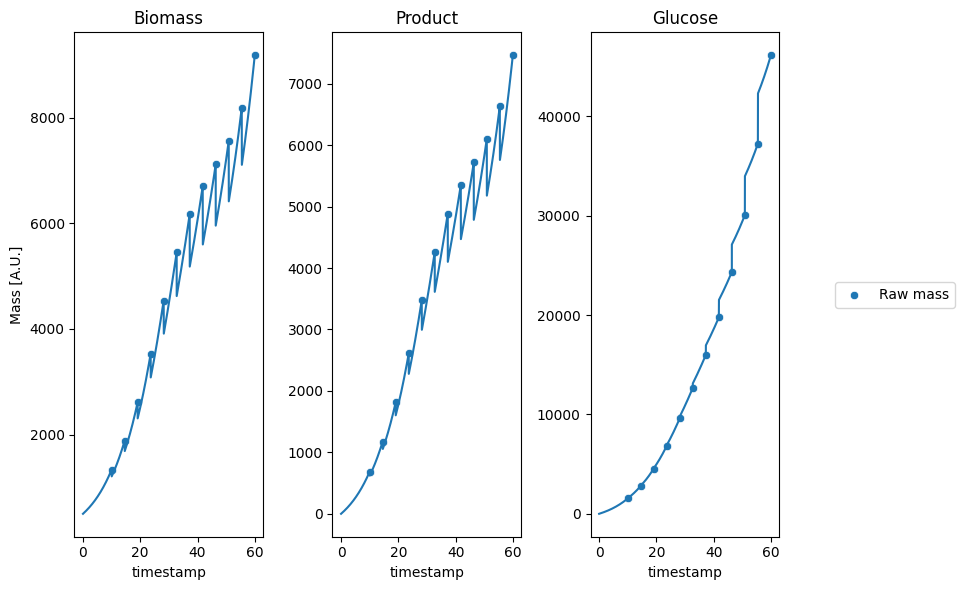

In [39]:
initial_volume = dat['v_Volume'].iloc[0]
fig, axes = plt.subplots(1,3)

sns.lineplot(x=dat['timestamp'], y = dat['m_Product'], ax=axes[1], label = 'Raw mass')
sns.lineplot(x=dat['timestamp'], y = dat['m_Biomass'], ax=axes[0], label = 'Raw mass')
sns.lineplot(x=dat['timestamp'], y = dat['m_consumed_Glucose'], ax=axes[2], label = 'Raw mass')

sns.scatterplot(x=dat_samples['timestamp'], y = dat_samples['m_Product'], ax=axes[1], label = 'Raw mass')
sns.scatterplot(x=dat_samples['timestamp'], y = dat_samples['m_Biomass'], ax=axes[0], label = 'Raw mass')
sns.scatterplot(x=dat_samples['timestamp'], y = dat_samples['m_consumed_Glucose'], ax=axes[2], label = 'Raw mass')

axes[1].set_title("Product")
axes[0].set_title("Biomass")
axes[2].set_title("Glucose")

for ax in axes:
    ax.get_legend().remove()
    ax.set_ylabel('')
axes[0].set_ylabel('Mass [A.U.]')

# drop duplicated labels
handles, labels = fig.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.set_size_inches((8,6))
fig.tight_layout()
fig.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.2, 0.5),
                         loc='center right', borderaxespad=0.)

fig.savefig(FIGURES_DIR / "mass_time_course_product_inhibit_raw_only.png", dpi = 300, bbox_inches='tight')